I need to figure out the polar coordinates, otherwise things just do not work

In [1]:
import numpy as np
import tensorflow as tf
import graph_nets as gn
import sonnet as snt
import matplotlib.pyplot as plt
import math

import read_orbits
from solar_system_names import *

Global Constants

In [2]:
# Global constants
AU = 149.6e6 * 1000 # Astronomical Unit in meters.
DAY = 24*3600. # Day in seconds
YEAR = 365.25*DAY #Year
delta_time = (2/24.) # 2 hours
MSUN = 1.9885e+30
MEARTH = 5.9724e+24
G = 6.67428e-11/AU**3*MEARTH*DAY**2

# Helper functions

In [3]:
# Based on the tensorflow_graphics package

def log10(x):
    #numerator = tf.log(x)
    #denominator = tf.log(tf.constant(10, dtype=numerator.dtype))
    #return numerator / denominator
    return tf.experimental.numpy.log10(x)

def cartesian_to_spherical_coordinates(point_cartesian, eps=None):
    """Function to transform Cartesian coordinates to spherical coordinates.
    This function assumes a right handed coordinate system with `z` pointing up.
    When `x` and `y` are both `0`, the function outputs `0` for `phi`. Note that
    the function is not smooth when `x = y = 0`.
    Note:
      In the following, A1 to An are optional batch dimensions.
    Args:
      point_cartesian: A tensor of shape `[A1, ..., An, 3]`. In the last
        dimension, the data follows the `x`, `y`, `z` order.
      eps: A small `float`, to be added to the denominator. If left as `None`,
        its value is automatically selected using `point_cartesian.dtype`.
      name: A name for this op. Defaults to `cartesian_to_spherical_coordinates`.
    Returns:
      A tensor of shape `[A1, ..., An, 3]`. The last dimensions contains
      (`r`,`theta`,`phi`), where `r` is the sphere radius, `theta` is the polar
      angle and `phi` is the azimuthal angle.
    """
    #with tf.compat.v1.name_scope(name, "cartesian_to_spherical_coordinates",
    #                             [point_cartesian]):
    #  point_cartesian = tf.convert_to_tensor(value=point_cartesian)

    #shape.check_static(
    #    tensor=point_cartesian,
    #    tensor_name="point_cartesian",
    #    has_dim_equals=(-1, 3))

    x, y, z = tf.unstack(point_cartesian, axis=-1)
    radius = tf.norm(tensor=point_cartesian, axis=-1)
    theta = tf.acos(
        tf.clip_by_value(tf.divide(z, radius), -1., 1.))
    phi = tf.atan2(y, x)
    return tf.stack((log10(radius), theta, phi), axis=-1)

def spherical_to_cartesian_coordinates(point_spherical, name=None):
    """Function to transform Cartesian coordinates to spherical coordinates.
    Note:
      In the following, A1 to An are optional batch dimensions.
    Args:
      point_spherical: A tensor of shape `[A1, ..., An, 3]`. The last dimension
        contains r, theta, and phi that respectively correspond to the radius,
        polar angle and azimuthal angle; r must be non-negative.
      name: A name for this op. Defaults to 'spherical_to_cartesian_coordinates'.
    Raises:
      tf.errors.InvalidArgumentError: If r, theta or phi contains out of range
      data.
    Returns:
      A tensor of shape `[A1, ..., An, 3]`, where the last dimension contains the
      cartesian coordinates in x,y,z order.
    """
    #with tf.compat.v1.name_scope(name, "spherical_to_cartesian_coordinates",
    #                           [point_spherical]):
    #point_spherical = tf.convert_to_tensor(value=point_spherical)

    #shape.check_static(
    #    tensor=point_spherical,
    #    tensor_name="point_spherical",
    #    has_dim_equals=(-1, 3))

    logr, theta, phi = tf.unstack(point_spherical, axis=-1)
    r = tf.pow(logr, 10)
    #r = asserts.assert_all_above(r, 0)
    tmp = r * tf.sin(theta)
    x = tmp * tf.cos(phi)
    y = tmp * tf.sin(phi)
    z = r * tf.cos(theta)
    return tf.stack((x, y, z), axis=-1)

In [4]:
def force_newton(x, m1, m2):
    return G*m1*m2/np.linalg.norm(x, axis = -1, keepdims=True)**3.*x

def reshape_senders_receivers(senders, receivers, batch_size, nplanets, nedges):
    ''' Reshape receivers and senders to use in graph'''
    x = np.arange(batch_size)
    xx = x.reshape(batch_size,1)
    y = np.ones(nedges)
    z = np.reshape(xx+y-1, batch_size*nedges)*nplanets

    senders = np.concatenate([senders]*batch_size) + z
    receivers = np.concatenate([receivers]*batch_size) + z
    
    return senders, receivers

def build_rotation_matrix(a,b,g):
    A0 = tf.stack([tf.cos(a)*tf.cos(b), tf.sin(a)*tf.cos(b), -tf.sin(b)], 
                  axis=0)
    A1 = tf.stack([tf.cos(a)*tf.sin(b)*tf.sin(g)-tf.sin(a)*tf.cos(g), 
                   tf.sin(a)*tf.sin(b)*tf.sin(g)+tf.cos(a)*tf.cos(g),
                   tf.cos(b)*tf.sin(g)], axis=0)
    A2 = tf.stack([tf.cos(a)*tf.sin(b)*tf.cos(g)+tf.sin(a)*tf.sin(g), 
                   tf.sin(a)*tf.sin(b)*tf.cos(g)-tf.cos(a)*tf.sin(g),
                   tf.cos(b)*tf.cos(g)], axis=0)
    
    return tf.stack((A0, A1, A2), axis=1)

def rotate_data(D, A):
    # I think the maxes should be 2pi, pi, pi, but going for overkill just in case
    alpha = tf.random.uniform([], minval=0, maxval=2*np.pi, dtype=tf.dtypes.float32)
    beta = tf.random.uniform([], minval=0, maxval=2*np.pi, dtype=tf.dtypes.float32)
    gamma = tf.random.uniform([], minval=0, maxval=2*np.pi, dtype=tf.dtypes.float32)
    #print(alpha) #It works! (Different every time)
    R = build_rotation_matrix(alpha,beta,gamma)
    #D = tf.einsum('ij,jk->ik', D,R)
    #A = tf.einsum('ij,jk->ik', A,R)
    D = tf.linalg.matmul(D,R)
    A = tf.linalg.matmul(A,R)
    return D, A

Training variables

In [5]:
# Training variables
patience = 5
d_patience = 0
noise_level = 0.05
log_every_iterations = 1000
num_training_iterations = 200000

# Do not change this
total_time_traj = 20 #Years
num_time_steps_total = int(total_time_traj/delta_time)
num_time_steps_tr = 130000 #An orbit for saturn is 129110 steps
num_time_steps_sr = 3000
num_batches = 1300
#num_time_steps_val = int(total_time_traj/delta_time) - num_time_steps_tr

Read the data

In [6]:
nplanets = 6 # Number of planets (not counting the sun)
data, masses, names = read_orbits.main(nplanets = nplanets, frame='b', use_moons = False, 
                                       path='/Users/Pablo/Dropbox/data/orbits/full/')
nplanets = len(data[0])
nedges = nplanets*(nplanets-1)//2
batch_size_tr = num_time_steps_tr//num_batches

# Get the acceleration
A = data[1:,:,3:] - data[:-1,:,3:]
data[:-1, :, 3:] = A/delta_time 
data = data[:-1]

masses/=MEARTH#/1000000

# Split into training and validation
data_tr = data[:num_time_steps_tr]
data_val = data[num_time_steps_tr:]

num_time_steps_val = len(data_val)

# Shuffle the data
np.random.shuffle(data_tr)
np.random.shuffle(data_val)

D_tr_np = np.empty([len(data_tr), nedges, 3])
D_val_np = np.empty([len(data_val), nedges, 3])
F_val = np.empty([len(data_val), nedges, 3])
k=0
names_edges = []
senders, receivers = [], []
for i in range(nplanets):
    for j in range(nplanets):
        if i > j:
            d_tr = data_tr[:,j,:3] - data_tr[:,i,:3]
            d_val = data_val[:,j,:3] - data_val[:,i,:3]
            D_tr_np[:,k,:] = d_tr#cartesian_to_spherical_coordinates(d_tr)
            D_val_np[:,k,:] = d_val #cartesian_to_spherical_coordinates(d_val)
            F_val[:,k,:] = force_newton(d_val, masses[i], masses[j]) #cartesian_to_spherical_coordinates(d_val)
            names_edges.append(names[j] + ' - ' + names[i])
            
            k+=1 
            receivers.append(i)
            senders.append(j)

A_tr = data_tr[:,:,3:]
A_val = data_val[:,:,3:]
A_norm =np.std(A_tr) 

A_norm_dim= tf.reduce_mean(tf.norm(A_tr/A_norm, axis = -1, keepdims = False), axis = 0)
A_norm_tr = tf.convert_to_tensor([A_norm_dim]*batch_size_tr, dtype="float32")
A_norm_tr = tf.reshape(A_norm_tr, shape = [batch_size_tr*nplanets, 1])
A_norm_val = tf.convert_to_tensor([A_norm_dim]*num_time_steps_val, dtype="float32")
A_norm_val = tf.reshape(A_norm_val, shape = [num_time_steps_val*nplanets, 1])

D_tr_flat = np.reshape(D_tr_np, [num_time_steps_tr*nedges, 3])
D_val_flat = np.reshape(D_val_np,[1, num_time_steps_val*nedges, 3])

A_tr_flat = np.reshape(A_tr/A_norm, [num_time_steps_tr*nplanets, 3])
A_val_flat = np.reshape(A_val/A_norm, [1, num_time_steps_val*nplanets, 3])

D_tr = tf.convert_to_tensor(D_tr_flat, dtype="float32")
A_tr = tf.convert_to_tensor(A_tr_flat, dtype="float32")
D_tr_batches = tf.split(D_tr,  num_batches)
A_tr_batches = tf.split(A_tr,  num_batches)

D_val = tf.convert_to_tensor(D_val_flat, dtype="float32")
A_val = tf.convert_to_tensor(A_val_flat, dtype="float32")

train_ds = tf.data.Dataset.from_tensor_slices(
    (D_tr_batches, A_tr_batches))#.batch(batch_size_tr)

test_ds = tf.data.Dataset.from_tensor_slices(
    (D_val, A_val))

#D_val = tf.convert_to_tensor(D_val[:,:,:], dtype="float32")
#A_val = tf.convert_to_tensor(A_val/A_norm, dtype="float32")

#D_val_flat = tf.reshape(D_val, shape = [num_time_steps_val*nedges, 3])
#A_val_flat = tf.reshape(A_val/A_norm, shape = [num_time_steps_val*nedges, 3])

nodes_tr = np.concatenate([np.log10(masses)]*batch_size_tr)[:,np.newaxis]
nodes_val = np.concatenate([np.log10(masses)]*num_time_steps_val)[:,np.newaxis]
nodes_sr = np.concatenate([np.log10(masses)]*num_time_steps_sr)[:,np.newaxis]

senders_tr, receivers_tr = reshape_senders_receivers(senders, receivers, batch_size_tr, nplanets, nedges)
senders_val, receivers_val = reshape_senders_receivers(senders, receivers, num_time_steps_val, nplanets, nedges)
senders_sr, receivers_sr = reshape_senders_receivers(senders, receivers, num_time_steps_sr, nplanets, nedges)

Reading data in Solar System barycenter reference frame
Reading data for mercury
Reading data for venus
Reading data for earth
Reading data for mars
Reading data for jupiter
Reading data for saturn
Finished reading data
The data array contains 7 bodies.


In [7]:
def mean_weighted_error(y_true, y_pred, norm):
    x = (y_pred - y_true)/norm*tf.reduce_mean(norm)

    return tf.reduce_mean(tf.reduce_sum(x**2, axis = -1))
    
class MeanWeightedError(tf.keras.metrics.Metric):
    def __init__(self, name="mean_weighted_error", **kwargs):
        super(MeanWeightedError, self).__init__(name=name, **kwargs)
        self.mwe = self.add_weight(name="mwe", initializer="zeros")

    def update_state(self, y_true, y_pred, norm):
        self.mwe.assign_add(mean_weighted_error(y_true, y_pred, norm))

    def result(self):
        return self.mwe

    def reset_states(self):
        # The state of the metric will be reset at the start of each epoch.
        self.mwe.assign(0.0)


In [8]:
#nplanets, _, ntime = X.shape
loss_tracker = tf.keras.metrics.Mean(name='loss')
#loss_test = tf.keras.metrics.MeanAbsoluteError(name='loss_test')
loss_test = MeanWeightedError(name='loss_test')

class LearnForces(tf.keras.Model):
    def __init__(self):
        super(LearnForces, self).__init__()
        self.test_loss_metric = tf.keras.metrics.MeanAbsoluteError(name='test_loss')
        self.nplanets = nplanets
        
        #m_init = tf.random_normal_initializer()
        #self.m = tf.Variable(
        #    initial_value=m_init(shape=(self.nplanets,), dtype="float32"),
        #    trainable=True,
        #)
        
        self.graph_network = gn.blocks.EdgeBlock(
            edge_model_fn=lambda: snt.nets.MLP([32, 32, 3]),
            #edge_model_fn=lambda: snt.nets.MLP([128,128,128,128, 3]),
            use_edges = True,
            use_receiver_nodes = True,
            use_sender_nodes = True,
            use_globals = False,
        )
        #self.graph_network = gn.modules.GraphNetwork(
            #edge_model_fn=lambda: snt.Linear(output_size=3),
            #node_model_fn=None,
            #global_model_fn=None,
            #edge_block_opt = {'use_edges': True, 
            #                  'use_receiver_nodes': True,
            #                  'use_sender_nodes': True,
            #                  'use_globals': False,
            #                 }
        #)

    def sum_forces(self, graph):
        b1_tr = gn.blocks.ReceivedEdgesToNodesAggregator(reducer = tf.math.unsorted_segment_sum)(graph)
        b2_tr = gn.blocks.SentEdgesToNodesAggregator(reducer = tf.math.unsorted_segment_sum)(graph)
        summed_forces = b1_tr-b2_tr
        return summed_forces
            
    def get_acceleration(self, forces, graph):
        acceleration_tr = tf.divide(forces, tf.pow(10.,graph.nodes))
        return acceleration_tr
        #output_ops_tr = tf.reshape(acceleration_tr, shape=[self.ntime, self.nplanets, 3])
        #return output_ops_tr
        
    def call(self, g, extract = False):
        #self.ntime = len(g.nodes)//nplanets
        g = g.replace(
            edges = cartesian_to_spherical_coordinates(g.edges))
        g = self.graph_network(g)
        g = g.replace(
            edges = spherical_to_cartesian_coordinates(g.edges))
        f = self.sum_forces(g)
        a = self.get_acceleration(f, g)
        if extract == True: 
            f = tf.reshape(g.edges, shape=[-1, nedges, 3]).numpy()
            a = tf.reshape(a, shape=[-1, nplanets, 3]).numpy()
            return a, f
        else: 
            return a
    
    def train_step(self, data):
        #if isinstance(data, tuple):
        #    data = data[0]
        # Unpack the data
        D, A = data
        
        D_rot, A_rot = rotate_data(D, A)
        
        D_noise = tf.random.normal(tf.shape(D), 0, noise_level, tf.float32)
        D_rot = D_rot + D_noise
                                   
        # Could make a "get_senders_receivers" function, that takes
        # nplanets and returns the arrays. 
        # Will also have to make one that gets the nodes from the 
        # masses it is learning
        # That will make everything more self contained

        # Randomly 3D rotate the data
        
        graph_dict = { 
          "nodes": nodes_tr,
          "edges": D_rot, 
          "receivers": receivers_tr, 
          "senders": senders_tr 
           } 
    
        g = gn.utils_tf.data_dicts_to_graphs_tuple([graph_dict])
    
        with tf.GradientTape() as tape:
            # Forward pass
            predictions = self(g)
            # Compute the loss
            loss = mean_weighted_error(A_rot, predictions, A_norm_tr)
        
        # Compute gradients
        trainable_vars = model.graph_network.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)
        
        # Update weights
        self.optimizer.apply_gradients(zip(gradients,trainable_vars))

        loss_tracker.update_state(loss)
        return {"loss": loss_tracker.result()}

    def test_step(self,data):
        # Unpack the data
        D, A = data
        
        graph_dict = { 
          "nodes": nodes_val,
          "edges": D, 
          "receivers": receivers_val,
          "senders": senders_val 
           } 

        g = gn.utils_tf.data_dicts_to_graphs_tuple([graph_dict])
        
        predictions = self(g)

        #self.A_pred = tf.reshape(predictions, shape=[-1, self.nplanets, 3])
        #loss_test = tf.keras.metrics.MeanAbsoluteError(A, predictions)
        #loss_tracker.update_state(loss_test)

        #self.losses.append(tf.keras.losses.MeanAbsoluteError)
        # Updates the metrics tracking the loss
        #self.compiled_loss(A, predictions, regularization_losses=self.losses) 
    
        # Update the metrics.
        #loss_test.update_state(A, predictions)
        loss_test.update_state(A, predictions, A_norm_val)
        
        return {"loss": loss_test.result()}
    
    @property
    def metrics(self):
        # We list our `Metric` objects here so that `reset_states()` can be
        # called automatically at the start of each epoch
        # or at the start of `evaluate()`.
        # If you don't implement this property, you have to call
        # `reset_states()` yourself at the time of your choosing.
        return [loss_tracker, loss_test]



In [11]:
checkpoint_filepath = './saved_models/test'

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', 
                                            verbose = 1,
                                            patience=10, 
                                            restore_best_weights=True)

checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath,
                                                 save_weights_only=False,
                                                save_best_only=True
                                                 verbose=1)
model = LearnForces()

#model.compile(run_eagerly=True)
model.compile()

In [29]:
model.fit(train_ds, 
          epochs = 1000, 
          verbose=2,
          #callbacks=[early_stopping], 
          callbacks=[early_stopping, checkpoint], 
          validation_data=test_ds
         )

Epoch 1/1000
1300/1300 - 2s - loss: 0.0151 - val_loss: 0.0037

Epoch 00001: val_loss improved from inf to 0.00366, saving model to ./saved_models/baseline
Epoch 2/1000
1300/1300 - 2s - loss: 0.0151 - val_loss: 0.0024

Epoch 00002: val_loss improved from 0.00366 to 0.00241, saving model to ./saved_models/baseline
Epoch 3/1000
1300/1300 - 2s - loss: 0.0151 - val_loss: 0.0044

Epoch 00003: val_loss did not improve from 0.00241
Epoch 4/1000
1300/1300 - 2s - loss: 0.0150 - val_loss: 0.0065

Epoch 00004: val_loss did not improve from 0.00241
Epoch 5/1000
1300/1300 - 2s - loss: 0.0151 - val_loss: 0.0111

Epoch 00005: val_loss did not improve from 0.00241
Epoch 6/1000
1300/1300 - 2s - loss: 0.0151 - val_loss: 0.0069

Epoch 00006: val_loss did not improve from 0.00241
Epoch 7/1000
1300/1300 - 2s - loss: 0.0151 - val_loss: 0.0031

Epoch 00007: val_loss did not improve from 0.00241
Epoch 8/1000
1300/1300 - 2s - loss: 0.0151 - val_loss: 0.0048

Epoch 00008: val_loss did not improve from 0.00241
Ep

In [33]:
model.load_weights(checkpoint_filepath)

model.evaluate(test_ds)

1/1 [==============================] - 0s 303ms/step - loss: 0.0024


0.0024087312631309032

# Evaluate on validation data

In [34]:
graph_dict = { 
          "nodes": nodes_val,
          "edges": D_val_flat[0], 
          "receivers": receivers_val, 
          "senders": senders_val 
           } 
    
g = gn.utils_tf.data_dicts_to_graphs_tuple([graph_dict])
ap ,fp = model(g, extract = True)


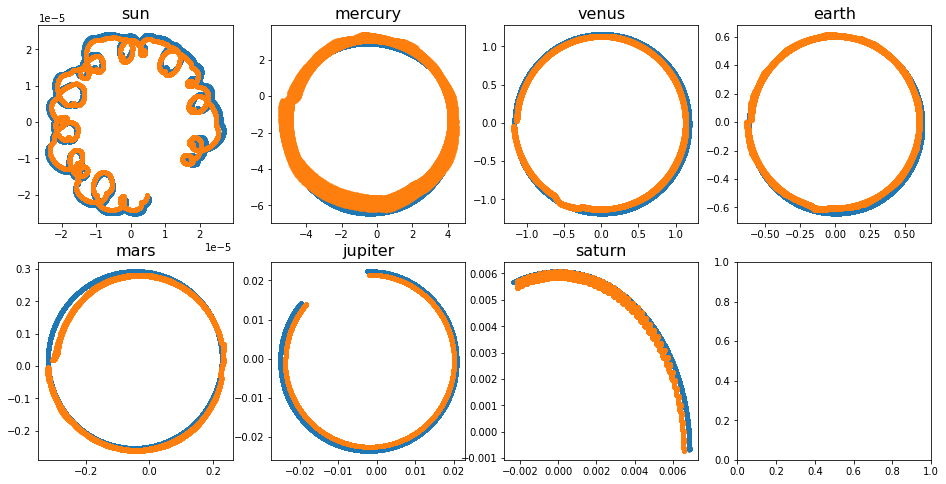

In [35]:
nrows = math.ceil(nplanets/4)
fig, ax = plt.subplots(nrows, 4, figsize = (16, 4*nrows))
for i in range(nplanets):
    ax[i//4, i%4].set_title(names[i], fontsize = 16)
    ax[i//4, i%4].plot(data_val[:,i,3]/A_norm, data_val[:,i,4]/A_norm, '.')
    ax[i//4, i%4].plot(ap[:,i,0], ap[:,i,1], '.')

#plt.savefig('/Users/Pablo/Desktop/moons.pdf')

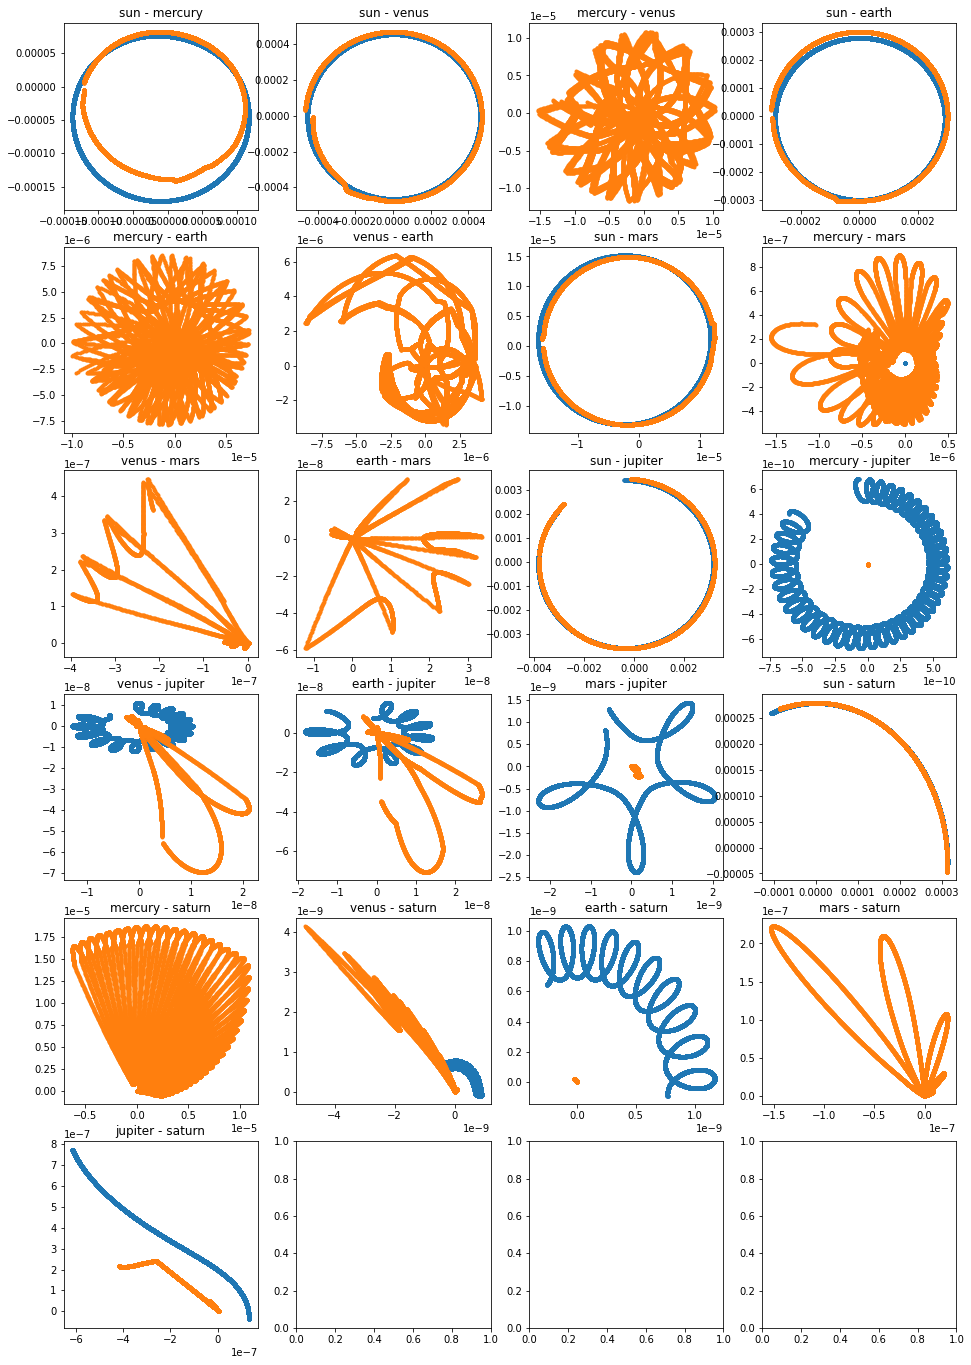

In [16]:
nrows = math.ceil(nedges/4)
fig, ax = plt.subplots(nrows, 4, figsize = (16, 4*nrows))
for i in range(nedges):
    ax[i//4, i%4].set_title(names_edges[i])
    ax[i//4, i%4].plot(F_val[:,i,0], F_val[:,i,1], '.')
    ax[i//4, i%4].plot(fp[:,i,0]*A_norm, fp[:,i,1]*A_norm, '.')

In [19]:
dv = tf.reshape(D_val, [-1, nedges, 3])
dv, fp = rotate_data(dv, fp)
F_pred_sr = np.empty([num_time_steps_sr, nedges, 3])
D_val_sr = np.empty([num_time_steps_sr, nedges, 3])
for i in range(num_time_steps_sr):
    Dv_temp, Fp_temp = rotate_data(dv[i], fp[i])
    F_pred_sr[i] = Fp_temp
    D_val_sr[i] = Dv_temp


In [ ]:
'''
indices = [0,1,3,6,10,15,21]
X = np.zeros([(nplanets-1)*num_time_steps_sr,5])
F = np.zeros([(nplanets-1)*num_time_steps_sr,3])
F_norm = np.mean(F_pred_sr)
k=0
for i in range(nplanets):
    for j in range(nplanets):
        if ((i>j) and (j==0)):
            print(i,j,k, indices[i])
            X[k*num_time_steps_sr:(k+1)*num_time_steps_sr,0] = masses[i]
           #X[k*num_time_steps_sr:(k+1)*num_time_steps_sr,1] = masses[j]
            X[k*num_time_steps_sr:(k+1)*num_time_steps_sr,1:4] = D_val_sr[:,indices[k],:]
            X[k*num_time_steps_sr:(k+1)*num_time_steps_sr,4] = np.linalg.norm(D_val_sr[:,indices[k],:], axis = -1)#**3
            F[k*num_time_steps_sr:(k+1)*num_time_steps_sr,:] = F_pred_sr[:,indices[k],:]#/F_norm #works better with
            k+=1
'''

In [23]:
X = np.zeros([nedges*num_time_steps_sr,6])
F = np.zeros([nedges*num_time_steps_sr,3])
F_norm = np.mean(F_pred_sr)
k=0
for i in range(nplanets):
    for j in range(nplanets):
        if i>j:
            X[k*num_time_steps_sr:(k+1)*num_time_steps_sr,0] = masses[i]
            X[k*num_time_steps_sr:(k+1)*num_time_steps_sr,1] = masses[j]
            X[k*num_time_steps_sr:(k+1)*num_time_steps_sr,2:5] = D_val_sr[:,k,:]
            X[k*num_time_steps_sr:(k+1)*num_time_steps_sr,5] = np.linalg.norm(D_val_sr[:,k,:], axis = -1)#**3
            F[k*num_time_steps_sr:(k+1)*num_time_steps_sr,:] = F_pred_sr[:,k,:]#/F_norm #works better with
            k+=1


In [24]:
D_val_sr.shape

(3000, 21, 3)

In [25]:
from pysr import pysr
# Learn equations
equations = []
for i in range(1):
    equation = pysr(X[:,:], F[:,i]/np.std(F[:,i]), niterations=50,
            #maxsize = 100,
            populations = 16,
            #variable_names = ['m0', 'm1', 'x', 'y', 'z', 'r'],
            binary_operators=["mult", "div"],
            unary_operators=["square", "cube"])
    equations.append(equation)

Running on julia -O3 -p 4 /var/folders/g2/89155hgd7fq1_lb47r__q4240000gn/T/tmpu5q0eetz/runfile.jl
Started!

Cycles per second: 8.210e+04
Hall of Fame:
-----------------------------------------
Complexity  MSE        Score     Equation
0           1.000e+00  0.000e+00  0.005709
5           9.183e-01  1.705e-02  mult(x2, div(0.57139194, x5))
7           9.183e-01  -0.000e+00  mult(div(0.47231108, div(x5, x2)), 1.2087828)
9           8.217e-01  5.556e-02  mult(x2, div(-0.42589864, div(x5, mult(x0, -0.010443743))))
10          8.095e-01  1.496e-02  mult(square(div(0.31503093, x5)), mult(mult(x0, x2), 0.2883437))

Killing process... will return when done.


In [26]:
equations[0]

,Complexity,MSE,score,Equation,sympy_format,lambda_format
0,5,0.918262,0.000000,"mult(x2, div(0.57139194, x5))",0.57139194*x2/x5,<function _lambdifygenerated at 0x7f9bb12ba710>
1,7,0.918262,-0.000000,"mult(div(0.47231108, div(x5, x2)), 1.2087828)",0.570921509753424*x2/x5,<function _lambdifygenerated at 0x7f9bb12bab90>
2,9,0.821687,0.055561,"mult(x2, div(-0.42589864, div(x5, mult(x0, -0....",0.00444797594020952*x0*x2/x5,<function _lambdifygenerated at 0x7f9b986c1050>
3,10,0.809487,0.014959,"mult(square(div(0.31503093, x5)), mult(mult(x0...",0.0286165225448521*x0*x2/x5**2,<function _lambdifygenerated at 0x7f9b986c13b0>


In [ ]:
def asCartesian(rthetaphi):
    #takes list rthetaphi (single coord)
    r       = rthetaphi[0]
    theta   = rthetaphi[1]* pi/180 # to radian
    phi     = rthetaphi[2]* pi/180
    x = r * sin( theta ) * cos( phi )
    y = r * sin( theta ) * sin( phi )
    z = r * cos( theta )
    return [x,y,z]

def asSpherical(xyz):
    #takes list xyz (single coord)
    x       = xyz[0]
    y       = xyz[1]
    z       = xyz[2]
    r       =  sqrt(x*x + y*y + z*z)
    theta   =  acos(z/r)*180/ pi #to degrees
    phi     =  atan2(y,x)*180/ pi
    return [r,theta,phi]

In [ ]:
X = np.zeros([nedges*num_time_steps_sr,6])
F = np.zeros([nedges*num_time_steps_sr,3])
F_norm = np.mean(F_pred_sr)
k=0
for i in range(nplanets):
    for j in range(nplanets):
        if i>j:
            X[k*num_time_steps_sr:(k+1)*num_time_steps_sr,0] = np.log10(masses[i])
            X[k*num_time_steps_sr:(k+1)*num_time_steps_sr,1] = np.log10(masses[j])
            X[k*num_time_steps_sr:(k+1)*num_time_steps_sr,2:5] = asSphericalD_val_sr[:,k,:]
            X[k*num_time_steps_sr:(k+1)*num_time_steps_sr,5] = np.linalg.norm(D_val_sr[:,k,:], axis = -1)#**3
            F[k*num_time_steps_sr:(k+1)*num_time_steps_sr,:] = F_pred_sr[:,k,:]#/F_norm #works better with
            k+=1



# TO DO:

### To finish the project
- Include moons
- Learn masses
- Use barycenter data directly

### To clean the model
- Clean mean_weighted_error implementation
- Include loss_test in fit 
- Use it for early stopping? 
- Make the model calculate the senders and receivers from input shape
- Include creating the graph in the model call, so the model takes an array of distances, not a graph? (Check if this makes things slower). See https://www.tensorflow.org/guide/keras/functional
- Make a separate script that creates the data
- Include some kind of training progress bar
- Improve plotting

# For next meeting
- So far, with the moons, even with the true masses given, the MLP struggles with learning. It gets stuck sending all edges involving the moons to zero. Suggestions?
- When I try to do symbolic regression with all edges (not just those involving the sun) PySR often struggles to find the correct formula, instead it gets stuck in things like m1*x or m0*x/r, even though when it does find the correct formula, it has a massively smaller MSE. Are there any settings I can give PySR to help it? It does work if I give it $r^3$ as a parameter, but that feels like cheating
- It keeps learning Saturn wrong, but I have no idea why

# Requirements
- The graphnets tensorflow 2 installation
- pysr

In [ ]:
plt.plot(data[:100,5,0], data[:100,5,1], '.')
plt.plot(data[:100,6,0], data[:100,6,1], '.')